In [1]:
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
import numpyro.infer as infer
from numpyro.infer import MCMC, NUTS
import tszpower
import numpy as np
from numpyro.infer.initialization import init_to_value

/Users/licongxu/envs/jax_env/lib/python3.12/site-packages/jax/_src/api_util.py:691: DeprecationWarning: Passing arguments 'a', 'a_min' or 'a_max' to jax.numpy.clip is deprecated. Please use 'arr', 'min' or 'max' respectively instead.
  ans = _fun(*args, **kwargs)


In [2]:
# Load the observed data and covariance
data_path="data/data_ps-ell-y2-erry2_total-planck-collab-15.txt"
D = np.loadtxt(data_path)
# Expected columns: ℓ, observed power spectrum, sigma.
ell_data = D[:, 0]
cl_obs = D[:, 1]
sigma_obs = D[:, 2]

covmat = jnp.diag(sigma_obs**2)
cl_obs = jnp.array(cl_obs)

In [3]:
# ----------------------------
# Define the NumPyro Model
# ----------------------------
def tsz_ps_model(cl_obs, cov, fg_template_path = 'data/data_fg-ell-cib_rs_ir_cn-total-planck-collab-15.txt'):
    """
    Model that computes the theoretical tSZ power spectrum (1-halo term)
    plus a foreground contribution and compares it to the observed power spectrum
    using a multivariate Gaussian likelihood.
    
    Parameters
    ----------
    fg_template_path : str
        Path to the foreground template file.
    cl_obs : jnp.array
        Observed power spectrum (1D array, length should match ell from compute_sz_power).
    cov : jnp.array
        The covariance matrix (non-diagonal) corresponding to cl_obs.
    """
    # --- Define Uniform Priors for 9 Parameters ---
    ln10_10A_s = numpyro.sample("ln10_10A_s", dist.Uniform(2.5, 3.5))
    omega_b    = numpyro.sample("omega_b",    dist.Uniform(0.02, 0.025))
    omega_cdm  = numpyro.sample("omega_cdm",  dist.Uniform(0.11, 0.13))
    H0         = numpyro.sample("H0",         dist.Uniform(55.0, 90.0))
    n_s        = numpyro.sample("n_s",        dist.Uniform(0.94, 1.0))
    B          = numpyro.sample("B",          dist.Uniform(1.0, 2.0))
    A_cib      = numpyro.sample("A_cib",      dist.Uniform(0.0, 5.0))
    A_rs       = numpyro.sample("A_rs",       dist.Uniform(0.0, 5.0))
    A_ir       = numpyro.sample("A_ir",       dist.Uniform(0.0, 5.0))
    
    # Combine into a single dictionary to pass to the theory functions.
    allparams = {
        "ln10_10A_s": ln10_10A_s,
        "omega_b":    omega_b,
        "omega_cdm":  omega_cdm,
        "H0":         H0,
        "n_s":        n_s,
        "B":          B,
        "A_cib":      A_cib,
        "A_rs":       A_rs,
        "A_ir":       A_ir
    }
    
    # --- Compute the Theoretical Power Spectrum ---
    # Compute the tSZ power spectrum (1-halo term)
    ell, cl_1h = tszpower.compute_sz_power(allparams)
    
    # Compute the foreground contribution
    cl_fg = tszpower.compute_foreground_lkl(allparams, fg_template_path=fg_template_path)
    
    # Sum the contributions
    cl_model = cl_1h + cl_fg

    # --- Likelihood ---
    # Compare the model prediction to the observed power spectrum.
    numpyro.sample("obs",
                   dist.MultivariateNormal(loc=cl_model, covariance_matrix=cov),
                   obs=cl_obs)


In [4]:
from functools import partial
from numpyro.infer.initialization import init_to_uniform

def safe_init_to_value(site=None, values={}):
    if site is None:
        # When called with no site, return a function that expects one.
        return partial(safe_init_to_value, values=values)
    # Try to access "type"; if missing, skip this site.
    try:
        if site["type"] == "sample" and not site.get("is_observed", False):
            # Use the provided value if available.
            if site["name"] in values:
                return values[site["name"]]
            else:
                return init_to_uniform(site)
    except KeyError:
        return None
    return None


In [5]:
init_vals = {
    "ln10_10A_s": 3.04,
    "omega_b": 0.0224,
    "omega_cdm": 0.119,
    "H0": 71.,
    "n_s": 0.96,
    "B": 1.41,
    "A_cib": 0.4,
    "A_rs": 0.0004,
    "A_ir": 1.8,
}

from numpyro.infer import MCMC, NUTS
kernel = NUTS(tsz_ps_model, init_strategy=safe_init_to_value(values=init_vals))
mcmc = MCMC(kernel, num_warmup=10, num_samples=10, num_chains=4)
rng_key = jax.random.PRNGKey(0)
mcmc.run(rng_key,
         cl_obs=cl_obs, 
         cov=covmat,
         fg_template_path='data/data_fg-ell-cib_rs_ir_cn-total-planck-collab-15.txt')


/var/folders/pk/xl4598515pb7q2jfw1tdzyr00000gn/T/ipykernel_53440/2497399289.py:15: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=10, num_samples=10, num_chains=4)
sample: 100%|██████████| 20/20 [21:38<00:00, 64.92s/it, 1023 steps of size 8.03e-03. acc. prob=0.90] 


In [6]:
# # ---------------------------
# # Run NUTS Sampling with NumPyro
# # ---------------------------
# rng_key = jax.random.PRNGKey(0)
# # Initialize the NUTS kernel with our model.
# kernel = NUTS(tsz_ps_model)
# # Set up the MCMC sampler.
# mcmc = MCMC(kernel, num_warmup=10, num_samples=10, num_chains=4)
# # Run the MCMC sampler.
# mcmc.run(rng_key, cl_obs=cl_obs, cov=covmat,
#          fg_template_path='data/data_fg-ell-cib_rs_ir_cn-total-planck-collab-15.txt')
# mcmc.print_summary()
# samples = mcmc.get_samples()

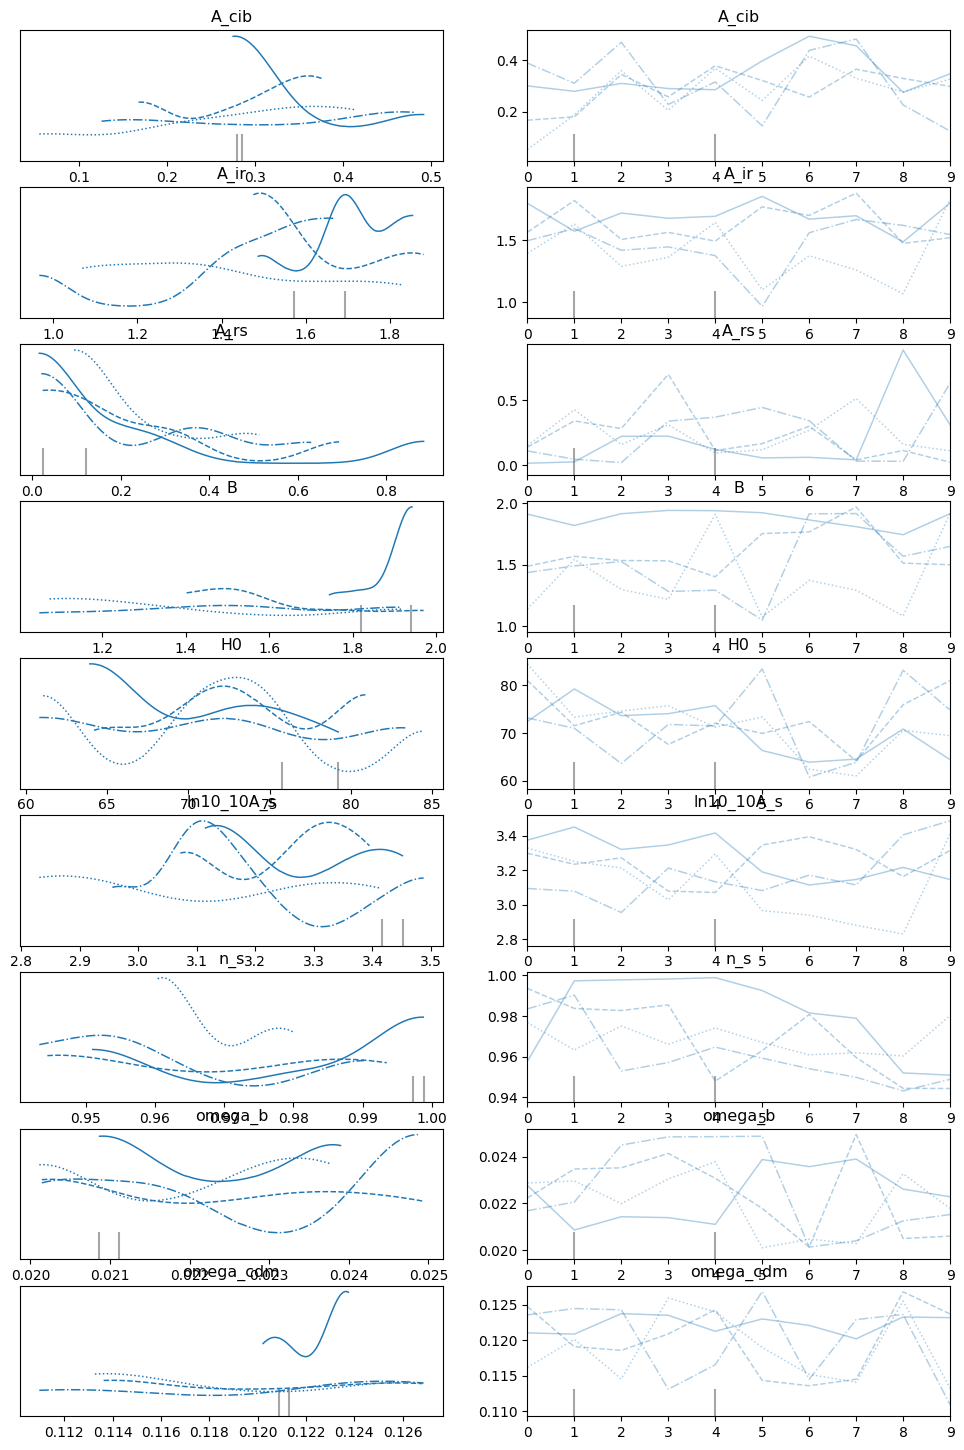

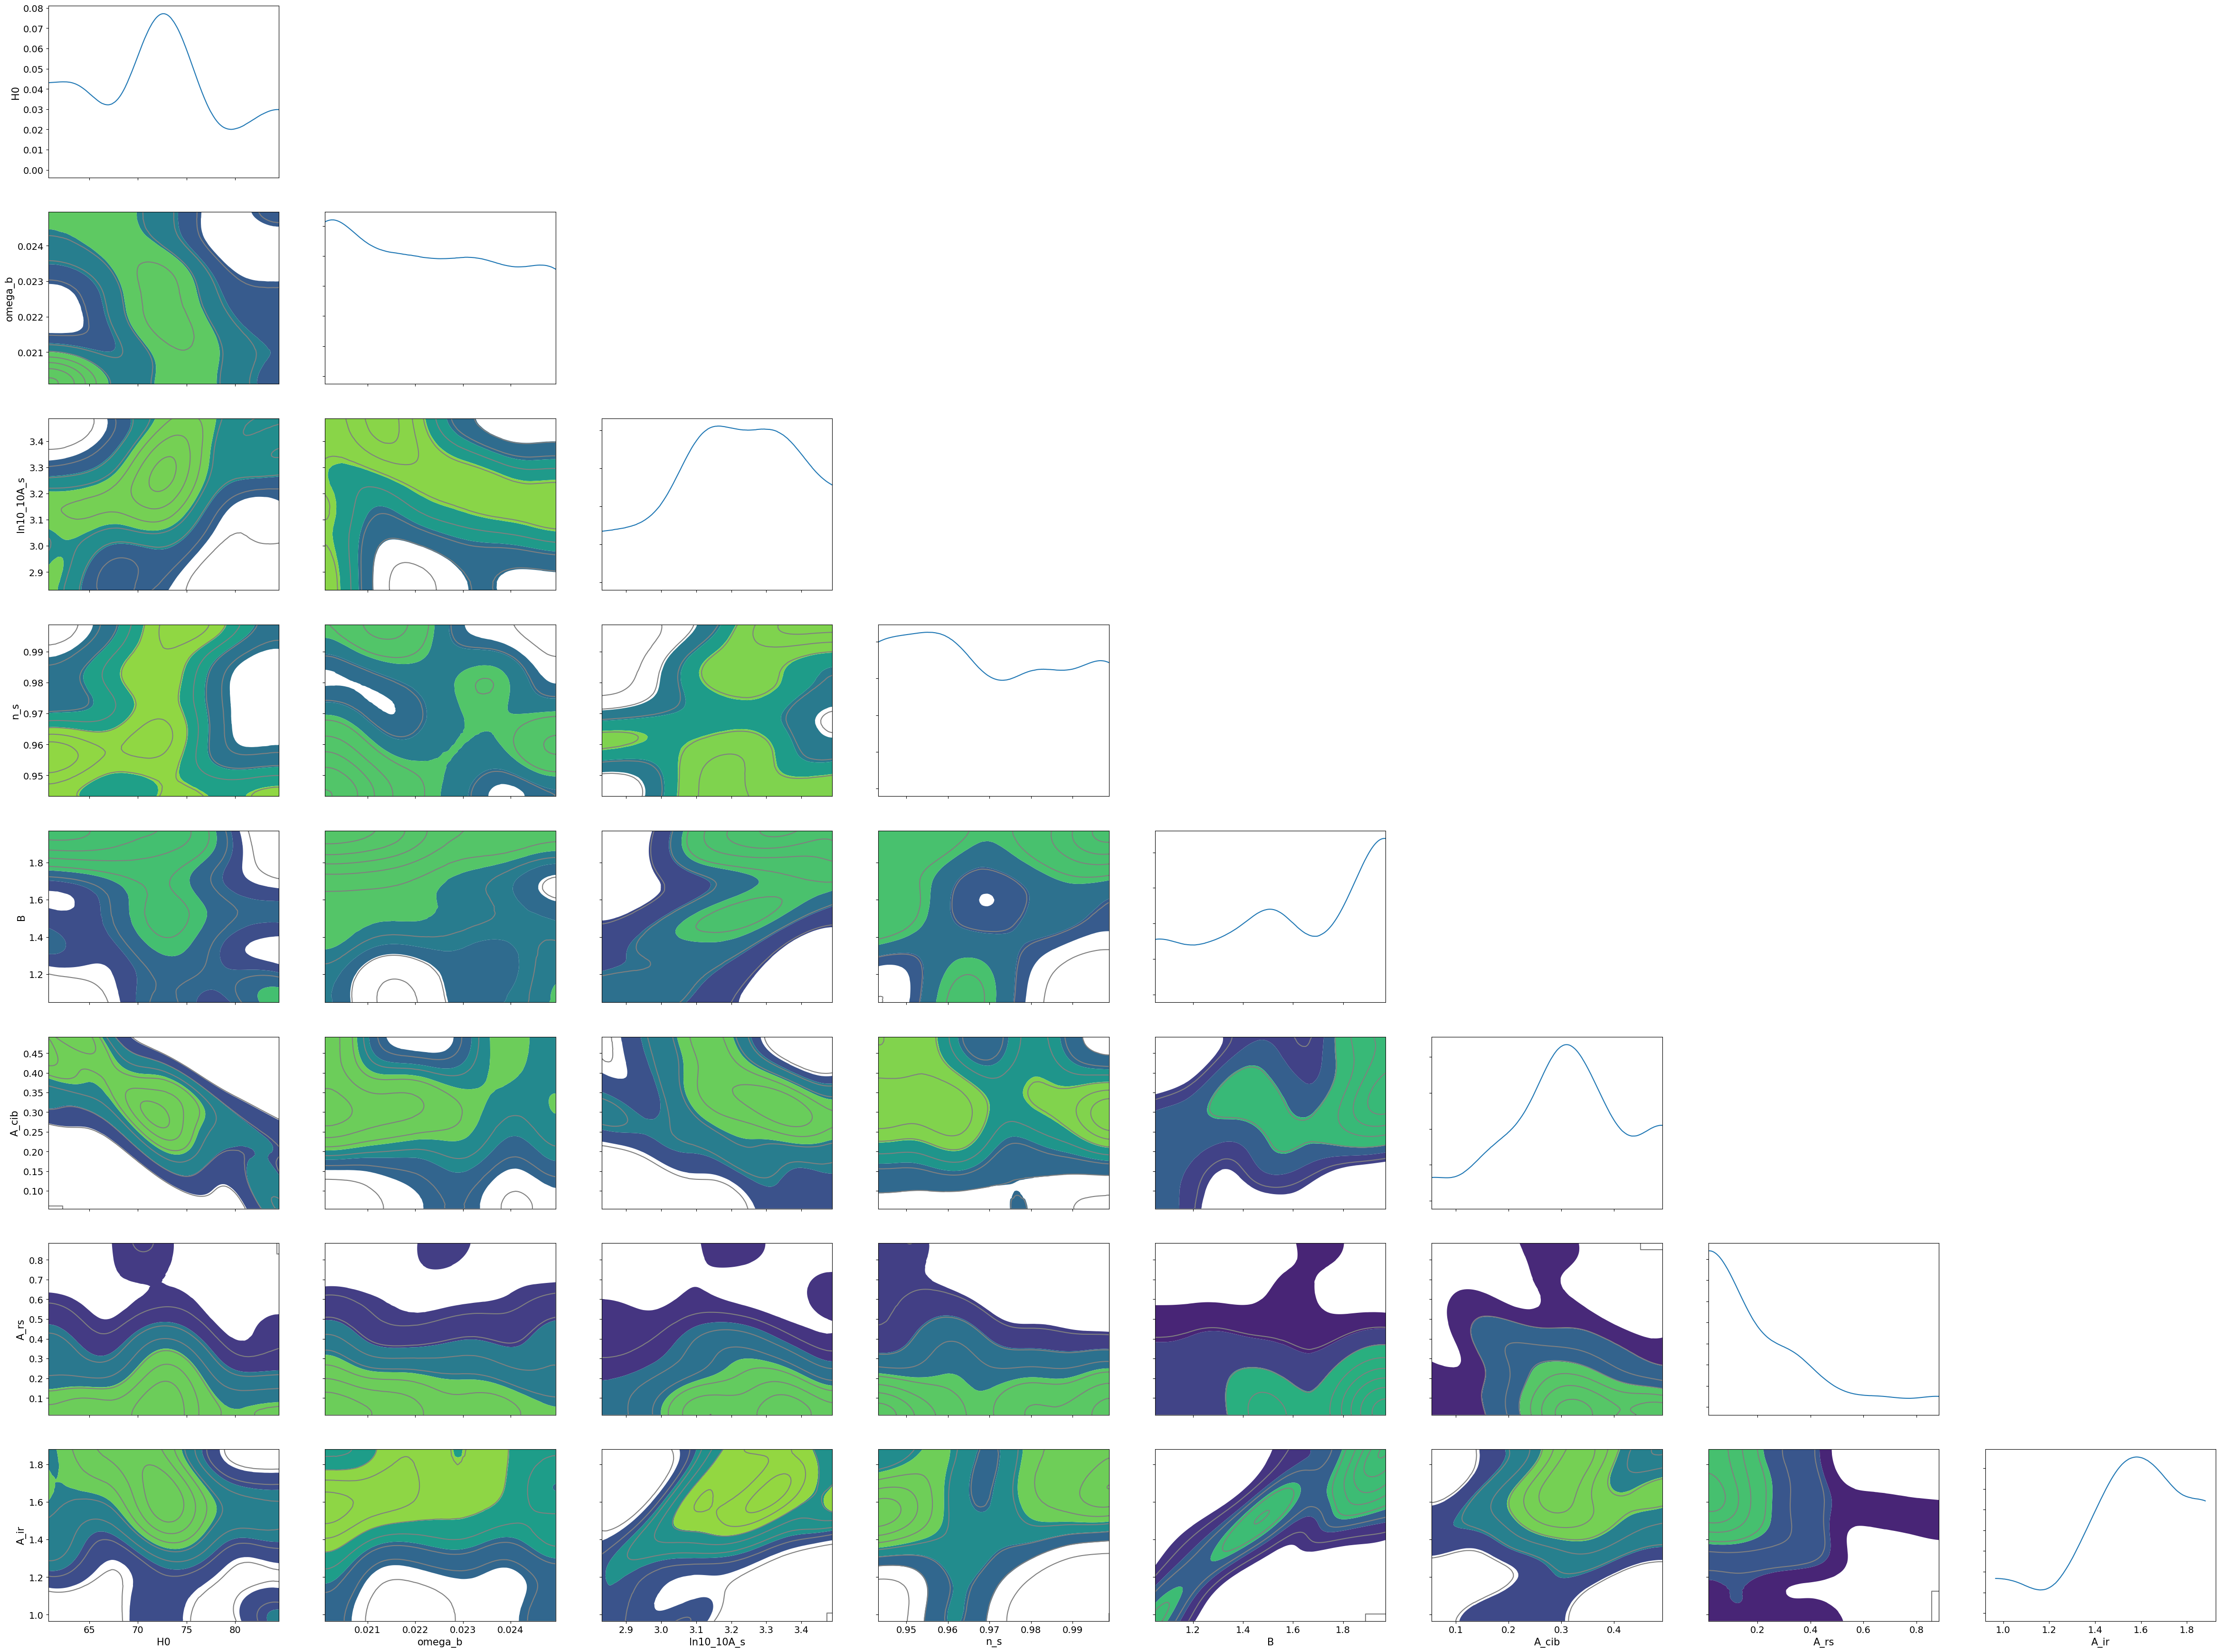

In [7]:
import arviz as az
import matplotlib.pyplot as plt

# Convert the MCMC samples to an ArviZ InferenceData object.
idata = az.from_numpyro(mcmc)

# Plot trace plots for all parameters.
az.plot_trace(idata)
plt.show()

# Optionally, create a pair plot (corner plot) for a subset of parameters.
# Adjust the list below to include the parameters you wish to compare.
az.plot_pair(
    idata,
    var_names=["H0", "omega_b", "ln10_10A_s", "n_s", "B", "A_cib", "A_rs", "A_ir"],
    kind="kde",
    marginals=True
)
plt.show()
